In [1]:
#importing required libraries
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential,save_model
from keras.layers import LSTM, Dense, Dropout,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight

In [2]:
#reading the csv files(preprocessed data and labels), selecting only the features extracted via RFC and storing the required in X and y
data = pd.read_csv('X_bb1.csv')
labels = pd.read_csv('Y_bb1.csv')
#features = ['Src_Port', 'Dst_Port', 'Protocol', 'Flow_Duration', 'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'Fwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Mean', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Bwd_Header_Len', 'Bwd_Pkts/s', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Std', 'Pkt_Len_Var', 'SYN_Flag_Cnt', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Subflow_Fwd_Byts', 'Subflow_Bwd_Byts', 'Init_Bwd_Win_Byts']

In [12]:
data.head()

,Src_Port,Dst_Port,Protocol,Fwd_Pkt_Len_Mean,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Mean,Flow_Pkts/s,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Max,...,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,SYN_Flag_Cnt,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Bwd_Win_Byts
0,-0.755714,2.349120,0.057529,8.143587,-0.006852,-0.190394,-0.509322,-0.369186,-0.359349,-0.370303,...,4.573562,2.983321,0.469744,2.052277,4.330851,8.143587,1.368650,0.231566,-0.028701,2.467652
1,1.621551,-0.564903,0.057529,-0.125587,7.258206,6.361782,-0.511086,-0.316301,-0.357990,-0.329411,...,5.333501,4.281757,0.977089,2.052277,5.012745,-0.125587,-0.000675,1.027469,0.954145,2.410597
2,0.793103,-0.586263,0.057529,-0.116262,0.025970,0.089400,-0.510807,-0.376674,-0.357270,-0.372019,...,-0.037344,0.083446,-0.048202,2.052277,-0.042850,-0.116262,-0.011785,-0.023999,-0.029403,2.410597
3,-0.773139,1.333690,0.057529,-0.154840,-0.147091,-0.250410,-0.509860,-0.378737,-0.361228,-0.374437,...,-0.282737,-0.234104,-0.053297,-0.487264,-0.297061,-0.154840,-0.012515,-0.053206,-0.031102,2.410553
4,1.945478,-0.564903,0.057529,0.020512,0.557090,1.302521,-0.511153,-0.371332,-0.357439,-0.372423,...,1.012869,0.867111,0.007975,2.052277,0.965162,0.020512,-0.003892,0.056322,-0.006254,2.410597


In [3]:
y=labels['Label'].values

In [4]:
#label encoding initialise phase
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(data)

In [6]:
#converting labels to one hot encoded format
num_classes = 3
y = to_categorical(y,num_classes=num_classes)
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [7]:
#splitting of train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [8]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
#LSTM model defining
model = Sequential()
model.add(LSTM(units=80, input_shape=(1,X_train.shape[2]), return_sequences=True,kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(LSTM(units=40,kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 80)             33920     
                                                                 
 dropout (Dropout)           (None, 1, 80)             0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 3)                 123       
                                                                 
Total params: 53403 (208.61 KB)
Trainable params: 53403 (208.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Define the early stopping monitor and patience
early_stopping_monitor = 'loss'
patience = 10

In [15]:
# Create an instance of the EarlyStopping callback
early_stopping = EarlyStopping(monitor=early_stopping_monitor, patience=patience, verbose=1, restore_best_weights=True)

# Add the early stopping callback to the model's callbacks
callbacks = [early_stopping]


In [16]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/100
5093/5093 [==============================] - 42s 7ms/step - loss: 0.1659 - accuracy: 0.9853 - val_loss: 0.0697 - val_accuracy: 0.9915
Epoch 2/100
5093/5093 [==============================] - 37s 7ms/step - loss: 0.0689 - accuracy: 0.9920 - val_loss: 0.0599 - val_accuracy: 0.9924
Epoch 3/100
5093/5093 [==============================] - 36s 7ms/step - loss: 0.0609 - accuracy: 0.9924 - val_loss: 0.0558 - val_accuracy: 0.9934
Epoch 4/100
5093/5093 [==============================] - 40s 8ms/step - loss: 0.0571 - accuracy: 0.9924 - val_loss: 0.0502 - val_accuracy: 0.9930
Epoch 5/100
5093/5093 [==============================] - 37s 7ms/step - loss: 0.0552 - accuracy: 0.9926 - val_loss: 0.0480 - val_accuracy: 0.9934
Epoch 6/100
5093/5093 [==============================] - 36s 7ms/step - loss: 0.0534 - accuracy: 0.9927 - val_loss: 0.0452 - val_accuracy: 0.9934
Epoch 7/100
5093/5093 [==============================] - 40s 8ms/step - loss: 0.0532 - accuracy: 0.9926 - val_loss: 0.0449 -

In [17]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

1274/1274 [==============================] - 5s 3ms/step


In [18]:
print(classification_report(y_test, y_pred,zero_division='warn'))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14706
           1       1.00      0.98      0.99     13685
           2       0.98      1.00      0.99     12351

   micro avg       0.99      0.99      0.99     40742
   macro avg       0.99      0.99      0.99     40742
weighted avg       0.99      0.99      0.99     40742
 samples avg       0.99      0.99      0.99     40742



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
y_test_labels = y_test.argmax(axis=1)
#fit and transform the labels
y_true_encoded = le.fit_transform(y_test_labels)
#convert predicted probability to labels
y_pred_labels = np.argmax(y_pred,axis=1)

In [23]:
#confusion matrix for the test set
confusion_mat = confusion_matrix(y_true_encoded,y_pred_labels)
confusion_mat

array([[14698,     0,     8],
       [   78, 13419,   188],
       [    0,     7, 12344]])

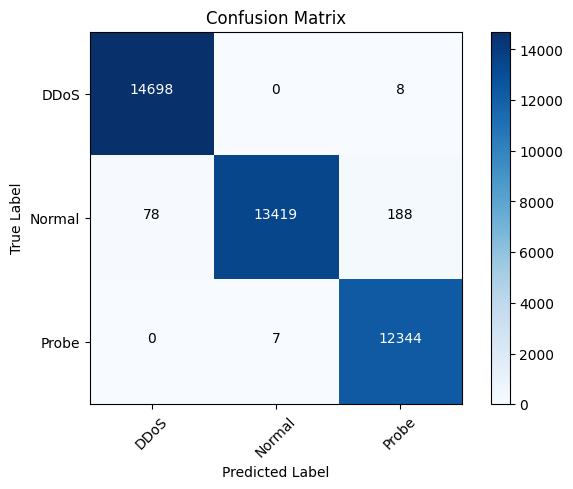

In [24]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix, classes, title):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plot_confusion_matrix(confusion_mat, ['DDoS', 'Normal', 'Probe'], "Confusion Matrix")
plt.show()

In [26]:
!pip install pydotplus

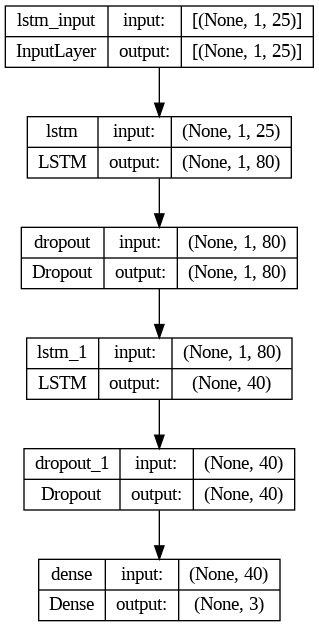

In [29]:
# Plot the model architecture
import pydotplus
from keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)